## Exercices 1: Elliptic PDE with singularity

We solve the 1D elliptic equation
$$
-(\sigma(x)u'(x))' = f(x), \quad x\in(0,\pi),\quad u(0)=u(\pi)=0.
$$

When $\sigma(x)$ is smooth, the solution $u(x)$ is $C^2$.
When $\sigma(x)$ is discontinuous (e.g. jumps at $x=\pi/2)$, the flux $\sigma u'$ remains continuous but $u'$ has a jump, so $u\in C^0$ but not $C^1$.

The strong form residual used in the loss is:
$$
r(x) =
\begin{cases}
-u''(x) - f(x), & \text{if } \sigma(x)=1,\\
-(\sigma(x)u'(x))' - f(x), & \text{if } \sigma(x)\text{ discontinuous.}
\end{cases}
$$

Loss function:
$$
\mathcal{L}(u_\theta) = \frac{1}{N}\sum_{i=1}^N r(x_i)^2.
$$

To satisfy $u(0)=u(\pi)=0$, we embed the boundary condition in the network:
$$
u_\theta(x) = x(\pi-x),\text{MLP}(x).
$$

For discontinuous cases, we add a **singularity-aware term**:
$$
u_\theta(x) = x(\pi-x)\left(u_0(x)+u_1(x)\frac{|x-\pi/2|^2}{2}\right).
$$

* **Adam:** standard stochastic gradient descent
  $$\theta_{t+1} = \theta_t - \eta,\nabla_\theta \mathcal{L}$$
* **Natural Gradient (NGD):**
  $$\theta_{t+1} = \theta_t - \eta,F^{-1}\nabla_\theta \mathcal{L},$$
  with diagonal Fisher approximation $F \approx \text{diag}(g^2+\varepsilon)$.

In [75]:
import jax, jax.numpy as jnp, equinox as eqx, optax, numpy as np
import matplotlib.pyplot as plt

key = jax.random.key(2025)

# ----------------------------
# Utilities
# ----------------------------
def make_mlp(ins, outs, key, width=64, depth=2):
    return eqx.nn.MLP(ins, outs, width, depth, activation=jax.nn.tanh, key=key)

def l2_err(u_pred, u_true, grid):
    dx = float(grid[1]-grid[0])
    return float(jnp.sqrt(jnp.sum((u_pred - u_true)**2)*dx))

def plot_curve(x, y_true, curves, labels, title="", xlabel="x", ylabel="u(x)", vline=None):
    plt.figure()
    plt.plot(x, y_true, 'k-', label='Analytic')
    for y, lbl, style in zip(curves, labels, ['r--','b:','g-.']):
        plt.plot(x, y, style, label=lbl)
    if vline is not None:
        plt.axvline(vline, ls='--', color='k', alpha=0.5)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(frameon=False); plt.tight_layout(); plt.show()

# ----------------------------
# Optim steps
# ----------------------------
@eqx.filter_jit
def step_adam(model, opt_state, opt, loss_fn, *args):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, *args)
    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

@eqx.filter_jit
def step_ngd(model, loss_fn, *args, lr=1e-3):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, *args)
    fisher = jax.tree_util.tree_map(lambda g: g**2 + 1e-6, grads)
    updates = jax.tree_util.tree_map(lambda g,f: -lr*g/f, grads, fisher)
    model = eqx.apply_updates(model, updates)
    return model, loss

def train(model, loss_fn, steps, optimizer="adam", lr=1e-3, print_every=1000, *args):
    print(f"\n=== {type(model).__name__} ({optimizer.upper()}) ===")
    if optimizer=="adam":
        opt = optax.adam(lr); opt_state = opt.init(eqx.filter(model, eqx.is_array))
        for e in range(steps):
            model, opt_state, loss = step_adam(model, opt_state, opt, loss_fn, *args)
            if e%print_every==0: print(f"{optimizer} step {e}: {float(loss):.2e}")
    else:
        for e in range(steps):
            model, loss = step_ngd(model, loss_fn, *args, lr=lr)
            if e%print_every==0: print(f"{optimizer} step {e}: {float(loss):.2e}")
    print(f"Final loss: {float(loss):.2e}")
    return model

In [76]:
f = lambda x: 4*jnp.sin(2*x)
def sigma_disc(x): return jnp.where(x<jnp.pi/2,3.,1.)

# --- Analytic Solutions for Ex1 ---
def u_true_disc_scalar(x):
    return jnp.where(x < jnp.pi/2, (1.0/3.0) * jnp.sin(2.0 * x), jnp.sin(2.0 * x))
def du_true_disc_scalar(x):
    return jnp.where(x < jnp.pi/2, (2.0/3.0) * jnp.cos(2.0 * x), 2.0 * jnp.cos(2.0 * x))

# --- Models Ex1 ---
class PINN1(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self, k): self.net=make_mlp(1,1,k,32,2)
    def __call__(self,x): y=self.net(jnp.array([x]))[0]; return x*(jnp.pi-x)*y

class PINN1S(eqx.Module):
    net0: eqx.nn.MLP; net1: eqx.nn.MLP
    def __init__(self,k): k1,k2=jax.random.split(k);self.net0=make_mlp(1,1,k1,32,2);self.net1=make_mlp(1,1,k2,32,2)
    def __call__(self,x):
        bc=x*(jnp.pi-x);u0=self.net0(jnp.array([x/jnp.pi]))[0];u1=self.net1(jnp.array([x/jnp.pi]))[0]
        return bc*(u0+u1*(jnp.abs(x-jnp.pi/2)**2/2))

# --- Loss Ex1 ---
def residual1(m,x,disc=False):
    if disc:
        dflux=jax.grad(lambda z:sigma_disc(z)*jax.grad(lambda y:m(y))(z))(x)
        return -dflux - f(x)
    else:
        d2u=jax.grad(lambda z:jax.grad(lambda y:m(y))(z))(x)
        return -d2u - f(x)
def loss1(m,xv,disc=False):
    r=jax.vmap(lambda xi:residual1(m,xi,disc))(xv)
    return jnp.mean(r**2)

# --- training sets & true solutions ---
xtrain=jnp.linspace(0,jnp.pi,129)[1:-1]; xplot=jnp.linspace(0,jnp.pi,400)
u_true_s_plot = jnp.sin(2*xplot)
u_true_d_plot = jax.vmap(u_true_disc_scalar)(xplot)
du_true_d_plot = jax.vmap(du_true_disc_scalar)(xplot)


=== PINN1 (ADAM) ===
adam step 0: 6.86e+00
adam step 500: 1.34e-03
adam step 1000: 1.61e-04
adam step 1500: 7.13e-05
adam step 2000: 3.33e-05
Final loss: 1.58e-05

=== PINN1 (NGD) ===
ngd step 0: 1.12e+01
ngd step 500: 3.84e+00
ngd step 1000: 1.24e+01
ngd step 1500: 1.30e+01
ngd step 2000: 8.67e+01
Final loss: 2.68e+01


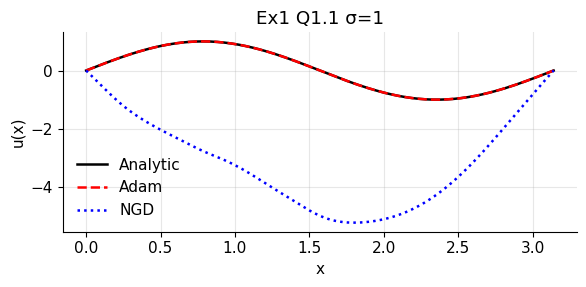

In [77]:
# --- Q1.1 ---
k1,k2,k3,k4,k5,k6=jax.random.split(key,6)
m11a=train(PINN1(k1),loss1,2500,"adam",1e-3,500,xtrain,False)
m11n=train(PINN1(k2),loss1,2500,"ngd",1e-3,500,xtrain,False)
u11a=jax.vmap(lambda x:m11a(x))(xplot); u11n=jax.vmap(lambda x:m11n(x))(xplot)
plot_curve(xplot, u_true_s_plot, [u11a,u11n], ["Adam","NGD"], "Ex1 Q1.1 σ=1")

Adam performs very well; NGD is slightly worse.


=== PINN1 (ADAM) ===
adam step 0: 5.50e+00
adam step 500: 2.68e-02
adam step 1000: 7.99e-03
adam step 1500: 5.47e-03
adam step 2000: 4.78e-03
adam step 2500: 4.30e-03
Final loss: 3.85e-03

=== PINN1 (NGD) ===
ngd step 0: 8.02e+00
ngd step 500: 1.10e+02
ngd step 1000: 1.56e+01
ngd step 1500: 1.32e+02
ngd step 2000: 9.42e+01
ngd step 2500: 4.80e+01
Final loss: 5.25e+01


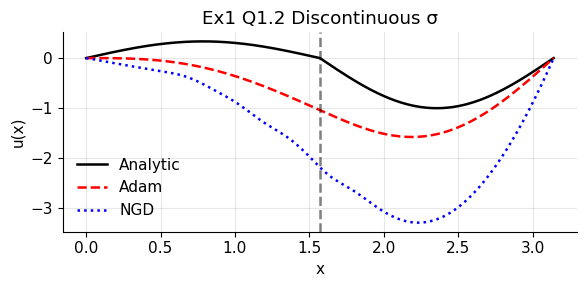

In [78]:
# --- Q1.2 ---
m12a=train(PINN1(k3),loss1,3000,"adam",1e-3,500,xtrain,True)
m12n=train(PINN1(k4),loss1,3000,"ngd",1e-3,500,xtrain,True)
u12a=jax.vmap(lambda x:m12a(x))(xplot);u12n=jax.vmap(lambda x:m12n(x))(xplot)

plot_curve(xplot, u_true_d_plot, [u12a,u12n], ["Adam","NGD"], "Ex1 Q1.2 Discontinuous σ", vline=jnp.pi/2)

Both are poor, but Adam is a bit better.


=== PINN1S (ADAM) ===
adam step 0: 7.73e+00
adam step 500: 1.69e-02
adam step 1000: 1.01e-02
adam step 1500: 7.38e-03
adam step 2000: 5.63e-03
adam step 2500: 5.23e-03
Final loss: 4.96e-03

=== PINN1S (NGD) ===
ngd step 0: 1.51e+01
ngd step 500: 1.10e+01
ngd step 1000: 7.35e+00
ngd step 1500: 2.52e+02
ngd step 2000: 5.21e+00
ngd step 2500: 1.50e+02
Final loss: 5.34e+02


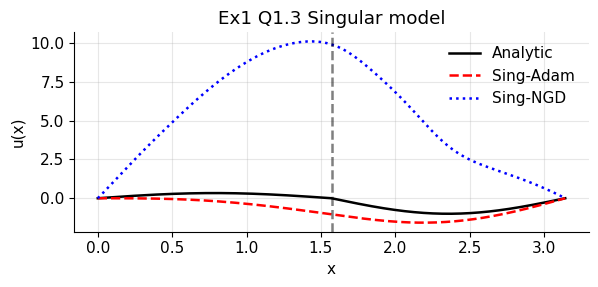

In [79]:
# --- Q1.3 ---
m13a=train(PINN1S(k5),loss1,3000,"adam",1e-3,500,xtrain,True)
m13n=train(PINN1S(k6),loss1,3000,"ngd",1e-3,500,xtrain,True)
u13a=jax.vmap(lambda x:m13a(x))(xplot);u13n=jax.vmap(lambda x:m13n(x))(xplot)

plot_curve(xplot, u_true_d_plot, [u13a,u13n], ["Sing-Adam","Sing-NGD"], "Ex1 Q1.3 Singular model", vline=jnp.pi/2)

Sing-Adam works clearly best; Sing-NGD is stable but less accurate.

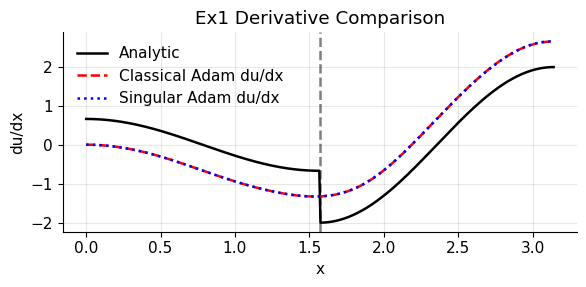

In [ ]:
du12a = jax.vmap(jax.grad(lambda z: m12a(z)))(xplot)
du13a = jax.vmap(jax.grad(lambda z: m13a(z)))(xplot)
plot_curve(
    xplot, du_true_d_plot,
    [du12a, du13a],
    ["Classical Adam du/dx", "Singular Adam du/dx"],
    "Ex1 Derivative Comparison",
    xlabel="x", ylabel="du/dx", vline=jnp.pi/2
)

## Exercices 2: Time PDE with singularity

We solve the 1D transport equation
$$
\partial_t u + c \partial_x u = 0, \quad (t,x)\in(0,T)\times(0,1), \quad u(0,x)=u_0(x).
$$

Its analytical solution is obtained by characteristics:
$$
u(t,x) = u_0(x-ct).
$$

For $c=1$ and $T=0.3$, boundary conditions are negligible.

Semi-Lagrangian Formulation
$$
\mathcal{L}(u_\theta) =
\underbrace{|u_\theta(t,x) - u_0(x-ct)|^2}_{\text{transport term}}
+ \underbrace{|u_\theta(0,x) - u_0(x)|^2}_{\text{initial condition term}}.
$$

* **Classical PINN2:** $u_\theta(t,x)=\text{MLP}(t,x)$
* **Singularity-aware PINN2S:**
$$
u_\theta(t,x) = u_0(t,x) + u_1(t,x)\frac{|x-\alpha(t)|^2}{2},\quad \alpha(t)\in(0,1)
$$
  where $\alpha(t)$ is learned as a moving singularity location.

In [81]:
T=0.3; c=1.0
def u0_gauss(x): return jnp.exp(-0.5*((x-0.5)/0.04)**2)
def u0_hat(x):   return jnp.clip(1-jnp.abs(x-0.5)/0.11,0,1)
def u_true_t(u0,t,x): return u0(x-c*t)

# --- Models Ex2 ---
class PINN2(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self,k): self.net=make_mlp(2,1,k,64,2)
    def __call__(self,t,x): return self.net(jnp.array([t,x]))[0]

class PINN2S(eqx.Module):
    net0: eqx.nn.MLP; net1: eqx.nn.MLP; a_net: eqx.nn.MLP
    def __init__(self,k):
        k1,k2,k3=jax.random.split(k,3)
        self.net0=make_mlp(2,1,k1,64,2);self.net1=make_mlp(2,1,k2,64,2);self.a_net=make_mlp(1,1,k3,16,1)
    def a(self,t): return jax.nn.sigmoid(self.a_net(jnp.array([t]))[0])
    def __call__(self,t,x):
        a=self.a(t);u0=self.net0(jnp.array([t,x]))[0];u1=self.net1(jnp.array([t,x]))[0]
        return u0+u1*(jnp.abs(x-a)**2)/2

# --- Loss & Sampling Ex2 ---
def make_sl_loss(u0):
    xic=jnp.linspace(0,1,128)
    @eqx.filter_jit
    def loss_fn(m,tv,xv):
        xb=xv-c*tv
        up=jax.vmap(lambda ti,xi:m(ti,xi))(tv,xv)
        ut=jax.vmap(lambda z:u0(z))(xb)
        ic=jax.vmap(lambda xi:m(0.,xi))(xic)
        return jnp.mean((up-ut)**2)+(jnp.mean((ic-jax.vmap(u0)(xic))**2))
    return loss_fn

def sample_tx(N=2048):
    k1, k2 = jax.random.split(jax.random.key(7))
    t = jax.random.uniform(k1, (N,), minval=0.0, maxval=T)
    u = jax.random.uniform(k2, (N,), minval=0.0, maxval=1.0)
    x = t * c + (1.0 - t * c) * u
    return t, x

# --- Plotting Ex2 ---
def plot_slices(models, labels, u0_fn, times, title_prefix=""):
    """Each time slice is plotted as a separate compact figure."""
    xs = jnp.linspace(0, 1, 300)
    for tt in times:
        u_true = jax.vmap(lambda x: u_true_t(u0_fn, tt, x))(xs)
        plt.figure()
        plt.plot(xs, u_true, 'k-', label='Analytic')
        for m, lbl, style in zip(models, labels, ['r--', 'b:', 'g-.']):
            u_pred = jax.vmap(lambda x: m(tt, x))(xs)
            plt.plot(xs, u_pred, style, label=lbl)
        plt.title(f"{title_prefix}  t={tt:.2f}")
        plt.xlabel("x"); plt.ylabel("u(x)")
        plt.legend(frameon=False, fontsize=9)
        plt.tight_layout(); plt.show()


# --- train sets ---
tb,xb=sample_tx()
lossG=make_sl_loss(u0_gauss); lossH=make_sl_loss(u0_hat)

key, k_ex2 = jax.random.split(key)
kg1,kg2,kg3,kh1,kh2,kh3=jax.random.split(k_ex2,6)


=== PINN2 (ADAM) ===
adam step 0: 2.02e-01
adam step 500: 6.59e-02
adam step 1000: 5.60e-04
adam step 1500: 3.33e-05
Final loss: 1.80e-05

=== PINN2 (NGD) ===
ngd step 0: 1.43e-01
ngd step 500: 4.23e+01
ngd step 1000: 1.94e+00
ngd step 1500: 1.86e+00
Final loss: 6.06e-01

=== PINN2S (NGD) ===
ngd step 0: 1.55e-01
ngd step 500: 2.30e+02
ngd step 1000: 1.33e+00
ngd step 1500: 1.36e+01
Final loss: 7.14e+00


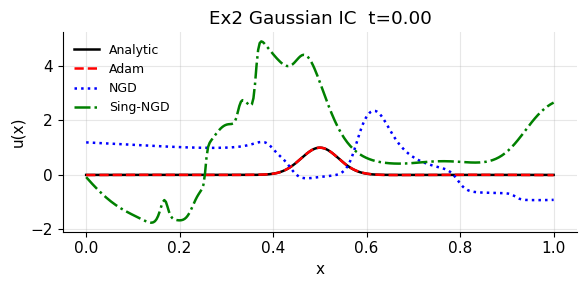

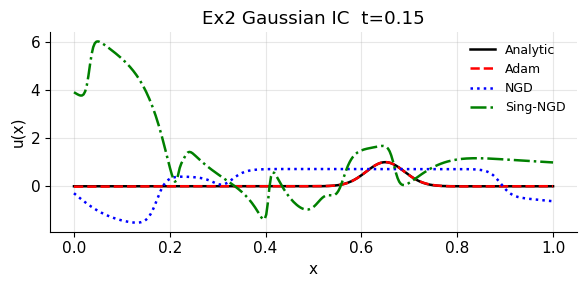

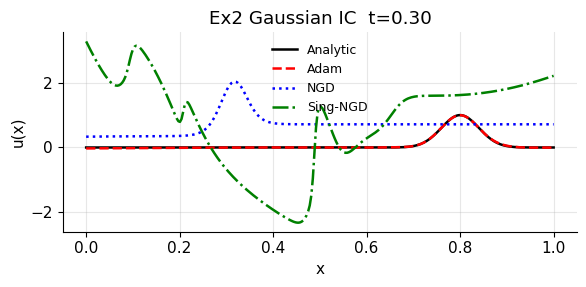

In [82]:
# --- Q2.1 / Q2.2 Gaussian ---
mG1=train(PINN2(kg1),lossG,2000,"adam",1e-3,500,tb,xb)
mG2=train(PINN2(kg2),lossG,2000,"ngd",1e-3,500,tb,xb)
mG3=train(PINN2S(kg3),lossG,2000,"ngd",1e-3,500,tb,xb)
plot_slices([mG1,mG2,mG3],["Adam","NGD","Sing-NGD"],u0_gauss,[0,0.15,0.3],"Ex2 Gaussian IC")


=== PINN2 (ADAM) ===
adam step 0: 1.56e-01
adam step 500: 7.53e-03
adam step 1000: 6.02e-04
adam step 1500: 5.30e-04
Final loss: 5.12e-04

=== PINN2S (ADAM) ===
adam step 0: 3.44e-01
adam step 500: 2.36e-02
adam step 1000: 1.07e-03
adam step 1500: 4.09e-04
Final loss: 2.40e-04

=== PINN2S (NGD) ===
ngd step 0: 1.39e-01
ngd step 500: 1.09e+02
ngd step 1000: 1.41e+00
ngd step 1500: 2.50e+02
Final loss: 4.06e+00


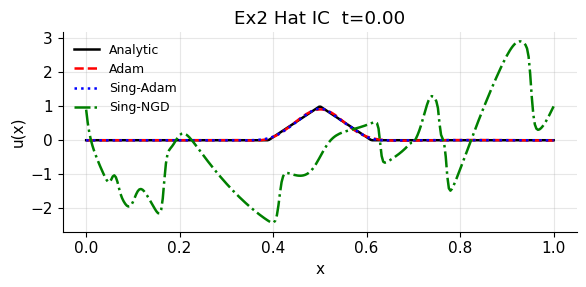

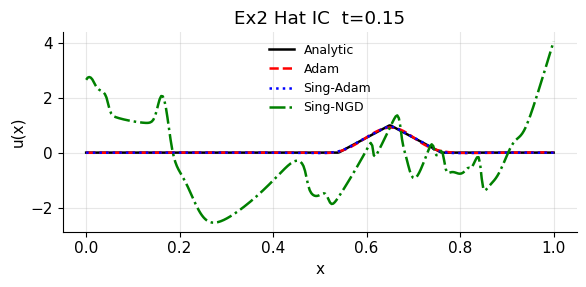

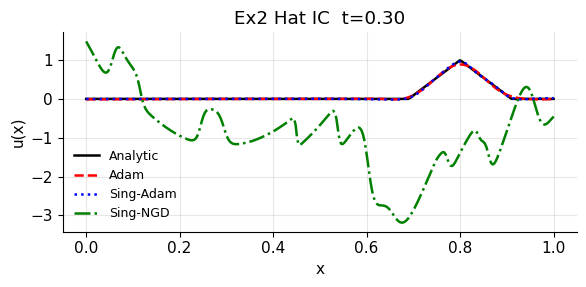

In [83]:
# --- Q2.1 / Q2.2 Hat ---
mH1=train(PINN2(kh1),lossH,2000,"adam",1e-3,500,tb,xb)
mH2=train(PINN2S(kh2),lossH,2000,"adam",1e-3,500,tb,xb)
mH3=train(PINN2S(kh3),lossH,2000,"ngd",1e-3,500,tb,xb)
plot_slices([mH1,mH2,mH3],["Adam","Sing-Adam","Sing-NGD"],u0_hat,[0,0.15,0.3],"Ex2 Hat IC")

Gaussian IC: Adam and Sing-Adam perform well; NGD is average.

Hat IC: Sing-Adam preserves the sharp front; NGD oversmooths it.

## Conclusion

- Adam achieves the best accuracy overall.  
- NGD is smoother but less precise.  
- Singularity-aware models significantly improve performance on discontinuous problems.  